# Clustering Documents(Images) in Visual NLP

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Install libs

In [ ]:
%pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install ../../../python/dist/spark-ocr-5.2.0rc2.tar.gz
%pip install kneed

## Start spark session

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark

Spark version: 3.4.1
Spark NLP version: 6.1.1
Spark NLP for Healthcare version: 6.0.3
Spark OCR version: 6.1.0



## Define pipeline for compute features

In [3]:
import os
import sys

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from pyspark.ml.feature import PCA, StandardScaler
from pyspark.ml.clustering import KMeans

from kneed import KneeLocator

In [4]:
binary_to_image = BinaryToImage() \
    .setInputCol("content") \
    .setOutputCol("image")

embeddings = VitImageEmbeddings \
    .pretrained("vit_image_embeddings", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("embeddings")

scaler = StandardScaler() \
    .setInputCol("embeddings") \
    .setOutputCol("scaled_embeddings")
                  
pca = PCA() \
    .setInputCol("scaled_embeddings") \
    .setOutputCol("pcaFeatures") \
    .setK(100)

pipeline = Pipeline(stages=[
     binary_to_image,
     embeddings,
     scaler,
     pca
])

vit_image_embeddings download started this may take some time.
Approximate size to download 303.6 MB


## Read images to the datafram and display it


    Image #0:
    Origin: file:/home/jose/.local/lib/python3.8/site-packages/sparkocr/resources/ocr/visualdoc/00556614_00556648.tif
    Resolution: 72 dpi
    Width: 784 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


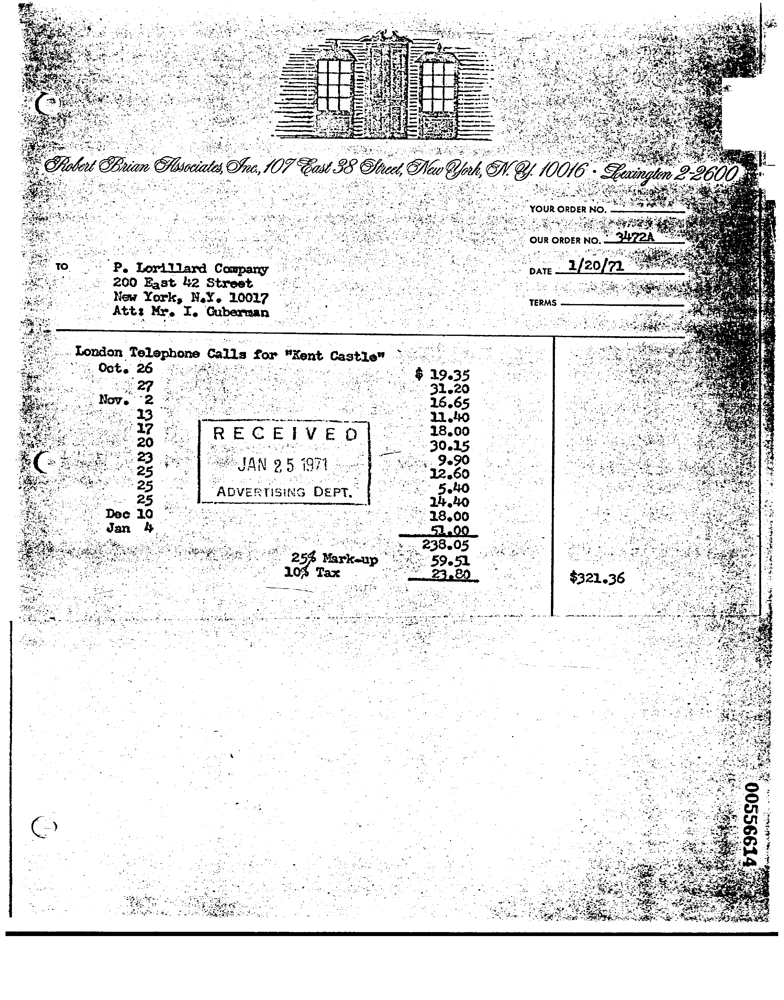


    Image #1:
    Origin: file:/home/jose/.local/lib/python3.8/site-packages/sparkocr/resources/ocr/visualdoc/50381376-1377.tif
    Resolution: 72 dpi
    Width: 754 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


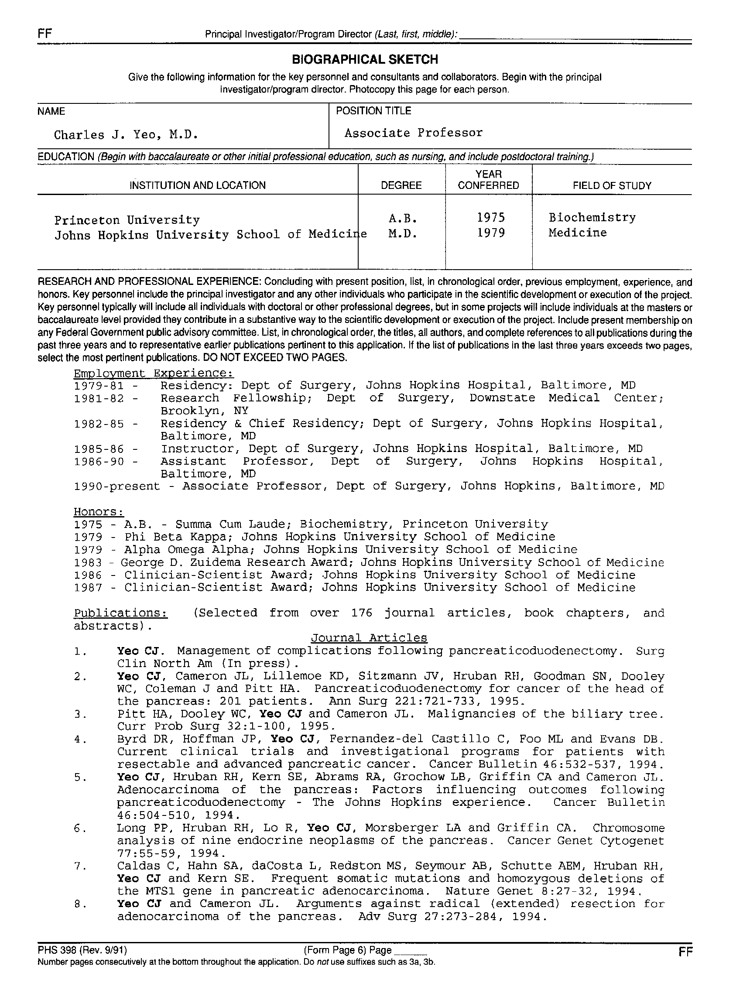


    Image #2:
    Origin: file:/home/jose/.local/lib/python3.8/site-packages/sparkocr/resources/ocr/visualdoc/0000157402.tif
    Resolution: 72 dpi
    Width: 762 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


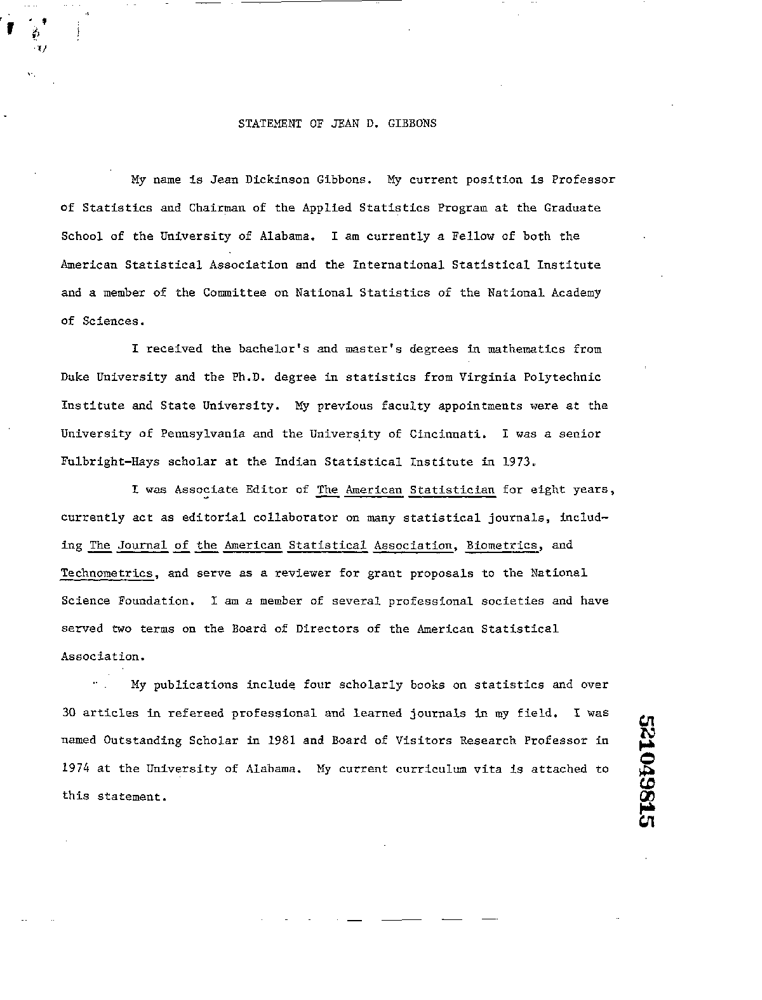


    Image #3:
    Origin: file:/home/jose/.local/lib/python3.8/site-packages/sparkocr/resources/ocr/visualdoc/00000337.tif
    Resolution: 72 dpi
    Width: 772 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


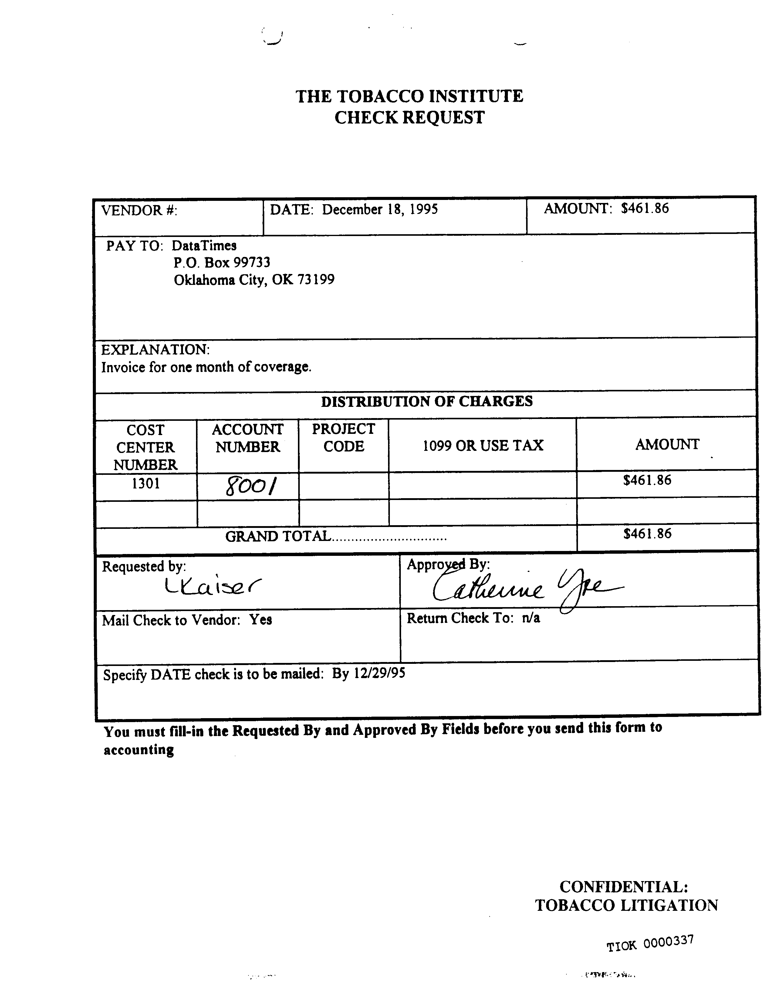


    Image #4:
    Origin: file:/home/jose/.local/lib/python3.8/site-packages/sparkocr/resources/ocr/visualdoc/92857051_7052.tif
    Resolution: 72 dpi
    Width: 802 px
    Height: 1000 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


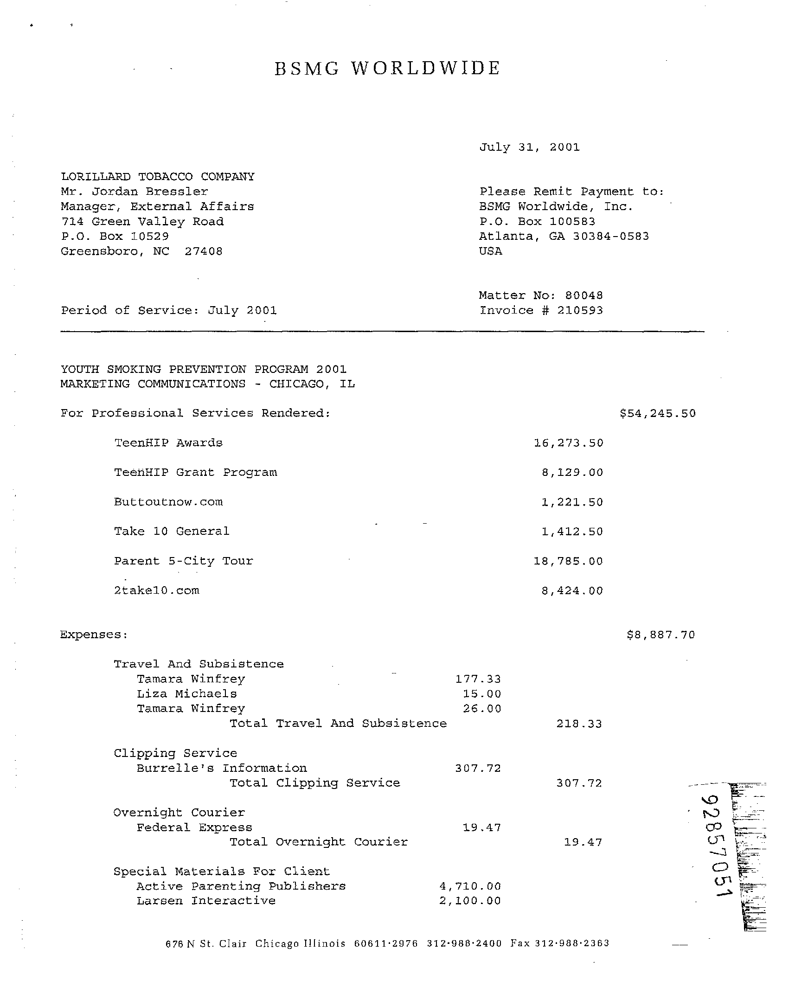

In [5]:
import pkg_resources
examples = pkg_resources.resource_filename('sparkocr', 'resources/ocr/visualdoc/*')
df = spark.read.format("binaryFile").load(examples).cache()
display_images(BinaryToImage().transform(df))

## Call pipeline for compute features

In [6]:
features = pipeline.fit(df).transform(df).cache()

## Elbow method to find the optimal  k

We will be using a knee point detection algorithm in order to automatically find the "elbow" which likely corresponds to the optimal value of k.

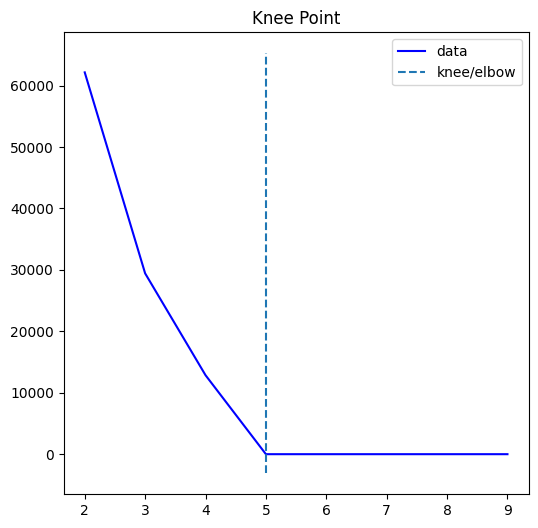

In [38]:
k_max = 10
ks_to_test = range(2, k_max)

distortions = []

upsampled = features.sample(withReplacement=True, fraction=30.0, seed=42)

for k in ks_to_test:
    kmeans = KMeans().setK(k).setSeed(1123).setFeaturesCol('pcaFeatures')
    try:
        model = kmeans.fit(upsampled)
        distortions.append(model.summary.trainingCost)
    except:
        distortions.append(float("inf"))
    
kneedle = KneeLocator(ks_to_test, distortions, curve="convex", direction="decreasing")
kneedle.plot_knee(figsize=(6,6))

k = kneedle.elbow

# Training a final model with the ideal  k

In [45]:
kmeans = KMeans(featuresCol='pcaFeatures', k=k)
model = kmeans.fit(features)
    
predicitions = model.transform(features)

In [46]:
predicitions.select("path", "prediction").show()

+--------------------+----------+
|                path|prediction|
+--------------------+----------+
|file:/Users/nmeln...|         1|
|file:/Users/nmeln...|         2|
|file:/Users/nmeln...|         3|
|file:/Users/nmeln...|         4|
|file:/Users/nmeln...|         0|
+--------------------+----------+



In [47]:
predicitions.groupBy("prediction").count().orderBy("prediction").toPandas()

,prediction,count
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
